In [1]:
import pandas as pd
import numpy as np
import random
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/H2GTRM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## Data Load

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# train = pd.read_csv('/content/drive/MyDrive/work/input/train.csv')
# test = pd.read_csv('/content/drive/MyDrive/work/input/test.csv')
# building_info = pd.read_csv('/content/drive/MyDrive/work/input/building_info.csv')
# submission = pd.read_csv('/content/drive/MyDrive/work/input/sample_submission.csv')
# train.shape, test.shape, building_info.shape, submission.shape

train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
building_info = pd.read_csv('input/building_info.csv')
submission = pd.read_csv('input/sample_submission.csv')
train.shape, test.shape, building_info.shape, submission.shape

((204000, 10), (16800, 7), (100, 7), (16800, 2))

## Train Data Pre-Processing

In [4]:
# 빌딩 데이터 정리
## null 처리
building_info['태양광용량(kW)'] = building_info['태양광용량(kW)'].str.replace('-','0').astype(float)
building_info['ESS저장용량(kWh)'] = building_info['ESS저장용량(kWh)'].str.replace('-','0').astype(float)
building_info['PCS용량(kW)'] = building_info['PCS용량(kW)'].str.replace('-','0').astype(float)

In [5]:
# 정리된 빌딩과 merge
train = train.merge(building_info, on='건물번호')
test = test.merge(building_info, on='건물번호')

In [6]:
#시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
train['month'] = train['일시'].apply(lambda x : int(x[4:6]))
train['day'] = train['일시'].apply(lambda x : int(x[6:8]))
train['time'] = train['일시'].apply(lambda x : int(x[9:11]))

test['month'] = test['일시'].apply(lambda x : int(x[4:6]))
test['day'] = test['일시'].apply(lambda x : int(x[6:8]))
test['time'] = test['일시'].apply(lambda x : int(x[9:11]))

In [7]:
# 요일
train['weekday'] =  pd.to_datetime(train['일시'].str[:8]).dt.weekday
test['weekday'] =  pd.to_datetime(test['일시'].str[:8]).dt.weekday

In [8]:
target_encoding = train.groupby(['건물유형']).agg({'전력소비량(kWh)':['min', 'mean','max']}).reset_index()
target_encoding.columns = ['건물유형', 'khw_min', 'khw_mean', 'khw_max']
train = train.merge(target_encoding, on=['건물유형'], how='left')
test = test.merge(target_encoding, on=['건물유형'], how='left')

In [9]:
train['냉방비율'] = ((train['냉방면적(m2)'] / train['연면적(m2)'])*100 ).astype(int)
test['냉방비율'] = ((test['냉방면적(m2)'] / test['연면적(m2)'])*100 ).astype(int)

train = train.drop(columns=['연면적(m2)','냉방면적(m2)'])
test = test.drop(columns=['연면적(m2)','냉방면적(m2)'])

In [10]:
#결측값을 0으로 채웁니다
train = train.fillna(0)
test = test.fillna(0)

In [11]:
train_x = train.drop(columns=['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'])
train_y = train['전력소비량(kWh)']

test_x = test.drop(columns=['num_date_time', '일시'])

In [12]:
#결측값을 0으로 채웁니다
train_x = train_x.fillna(0)
train_y = train_y.fillna(0)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_x , train_y ,test_size=0.2, shuffle=True, random_state=42, stratify=train_x['건물번호'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(163200, 17) (40800, 17) (163200,) (40800,)


## Regression Model Fit

In [14]:
# feature importance 
def vis_feature_importances_(est, X_train):
    ftr_importances_values = est.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    plt.figure(figsize=(10,4))
    plt.title('Feature importances Top 20')
    sns.barplot(x=ftr_top20 , y = ftr_top20.index)
    plt.show()

,건물유형,score
0,건물기타,0.0516521


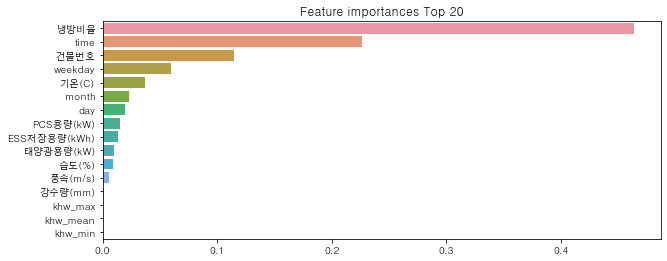

,건물유형,score
0,공공,0.0397581


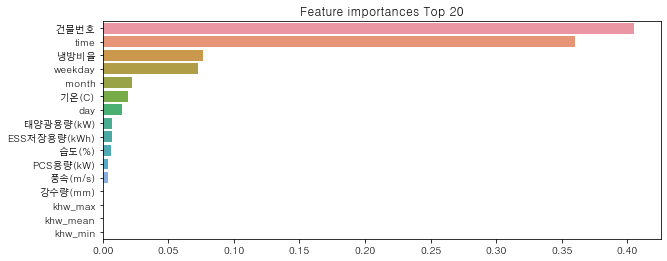

,건물유형,score
0,대학교,0.035222


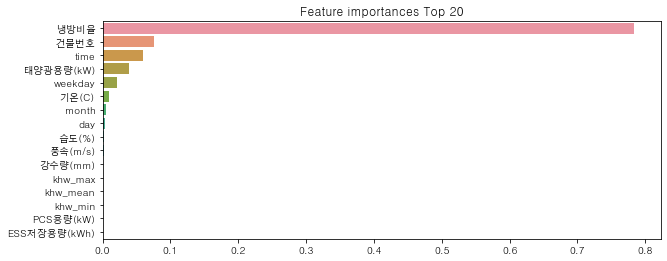

,건물유형,score
0,데이터센터,0.00376356


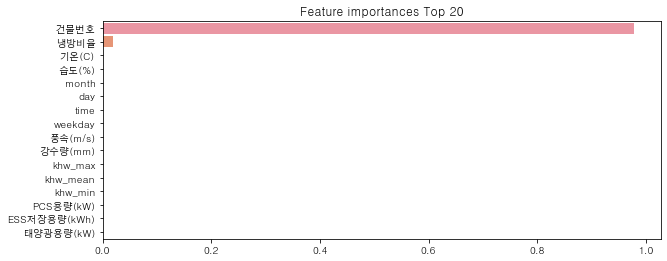

,건물유형,score
0,백화점및아울렛,0.0546978


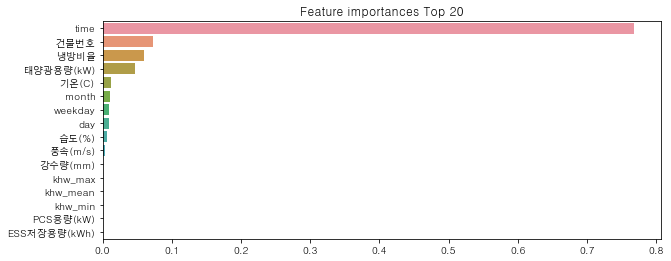

,건물유형,score
0,병원,0.0261959


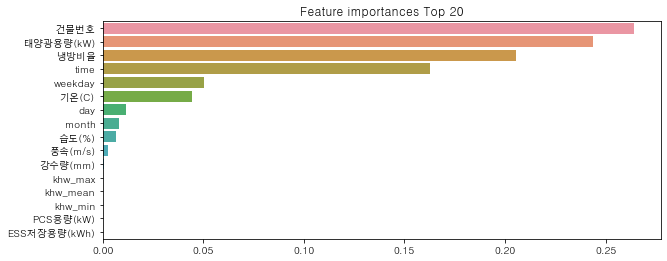

,건물유형,score
0,상용,0.0411688


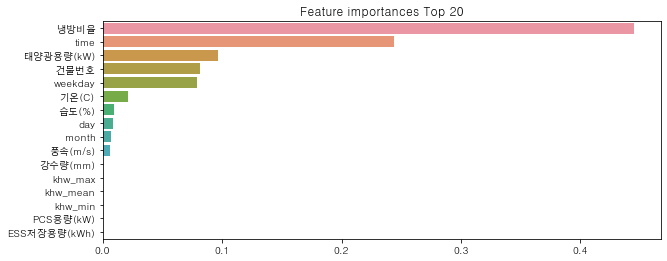

,건물유형,score
0,아파트,0.0406536


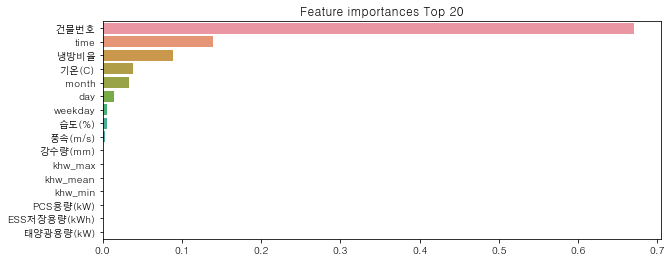

,건물유형,score
0,연구소,0.0337134


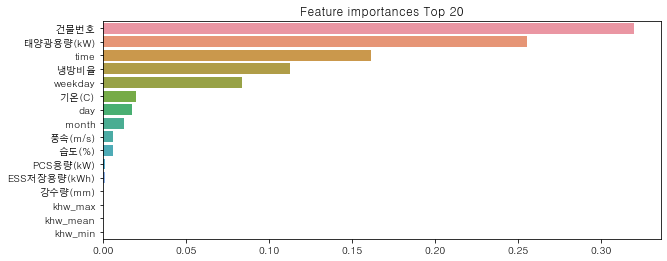

,건물유형,score
0,지식산업센터,0.0381616


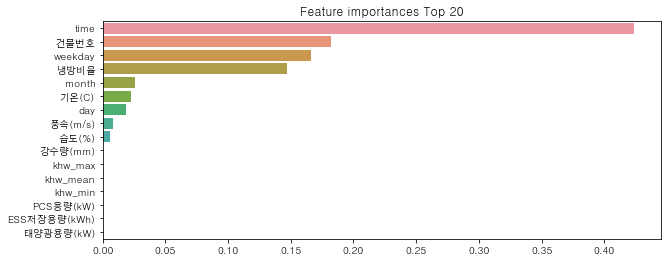

,건물유형,score
0,할인마트,0.049633


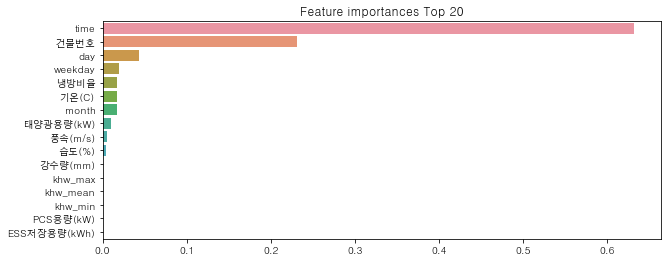

,건물유형,score
0,호텔및리조트,0.0555208


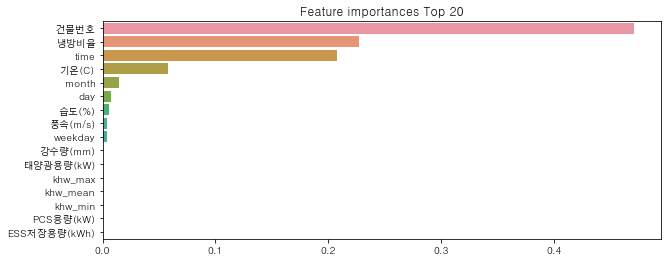

Wall time: 1min 5s


0.039178391947099205

In [15]:
%%time 
metrics = pd.DataFrame()
for i in train['건물유형'].unique():
    
    temp_X_train = X_train[X_train['건물유형'] == i].drop('건물유형', axis=1)
    temp_y_train = y_train.loc[temp_X_train.index]
    temp_X_test = X_test[X_test['건물유형'] == i].drop('건물유형', axis=1)
    temp_y_test = y_test.loc[temp_X_test.index]
    
    model = RandomForestRegressor(random_state=42)
    model.fit(temp_X_train, temp_y_train)
    y_preds = model.predict(temp_X_test)
    
    temp = pd.DataFrame([i, mean_absolute_percentage_error(temp_y_test, y_preds)]).T
    temp.columns = ['건물유형', 'score']
    metrics = metrics.append(temp)
    display(temp)
    vis_feature_importances_(model, temp_X_train)    
    
metrics['score'].mean()    

In [30]:
metrics.score.mean()

0.039178391947099205

In [16]:
metrics.to_excel('유형별.xlsx')

## Inference & Submit

In [31]:
%%time
result = pd.DataFrame()
for i in train['건물유형'].unique():
    
    temp_X_train = train[train['건물유형'] == i].drop(['건물유형','num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'], axis=1)
    temp_y_train = train.loc[temp_X_train.index][['전력소비량(kWh)']]
    
    model = RandomForestRegressor(random_state=42)
    model.fit(temp_X_train, temp_y_train)
                                                 
    temp_test = test[test['건물유형'] == i].drop(['건물유형','num_date_time', '일시'], axis=1)
    y_preds = model.predict(temp_test)
    result = result.append( pd.concat([test[test['건물유형'] == i].reset_index(), pd.DataFrame(y_preds, columns=['answer']).reset_index()], axis=1) )
    
result.shape    

Wall time: 1min 7s


(16800, 22)

In [32]:
submission.drop('answer', axis=1).merge(result[['num_date_time','answer']], on='num_date_time')#.to_csv('20230722-1.csv', index=False)

,num_date_time,answer
0,1_20220825 00,2050.8432
1,1_20220825 01,2098.0032
2,1_20220825 02,1969.8672
3,1_20220825 03,1968.8736
4,1_20220825 04,1962.6816
...,...,...
16795,100_20220831 19,855.9168
16796,100_20220831 20,710.1696
16797,100_20220831 21,731.1528
16798,100_20220831 22,634.8756
